# Exploring a Data Repository

<br>Owner: **Rob Morgan** ([@rmorgan10](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@rmorgan10)), **Phil Marshall** ([@drphilmarshall](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@drphilmarshall)), **Alex Drlica-Wagner** ([@kadrlica](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica))
<br>Some minor updates by:   Douglas Tucker ([@douglasleetucker](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@douglasleetucker))
<br>Last Verified to Run: **2021-03-12**
<br>Verified Stack Release: **v21.0.0**

This notebook examines the content of a data repository -- in this particular case, an HSC data repository -- and shows how to determine the inputs for each component. A related notebook is "Exploring a DC2 Data Repository," which explores the same basic concepts, but using a DC2 data repository; this other notebook covers matters in a slightly differ manner, though, and it is useful to explore both notebooks for a fuller understanding of data repositories.

### Learning Objectives:
After working through and studying this notebook you should be able to understand how to use the Butler to figure out: 
   1. What a data repo is;
   2. Which data types are present in a data repository;
   3. If coadds have been made, what the available tracts are;
   4. Which parts of the sky those tracts cover.
   
### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.


## Set Up

In [1]:
import os
import sys
import subprocess as sub
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import numpy as np
import os, glob
%matplotlib inline

## What is a Data Repo?

A data repo is a directory containing raw images, calibration files, metadata and configuration information, defining an LSST-format dataset. Data repositories contain either a `_mapper` file or a `repositoryCfg.yaml` file, which record the "obs package" that was used to organize the data. The obs package gives the repository more structure and organization than an ordinary data directory. Let's take a look at this file structure in the HSC data repo.

### The HSC Data Repo: What's in there?

We'll use the `hsc` data repository as our testing ground, and start by figuring out what it contains. In the `hsc` case, the `_mapper` file is in the top level folder, while the data repo for each field is a few levels down.

In [2]:
repo = '/datasets/hsc/repo'

In [3]:
! ls /datasets/hsc/repo/

10NP2P31       DEEPE08	     HIP67879		     SP01
11NM5P21       DEEPE09	     M31		     SR01
ABELL2163      DEEPE10	     M31_N		     SSP_AEGIS
algorithmData  DEN_A	     M31_S		     SSP_DEEP_COSMOS
BIAS	       DEN_C	     _mapper		     SSP_DEEP_DEEP2_3
CALIB	       DEN_E	     MOON_LIGHT		     SSP_DEEP_ELAIS_N1
CFHTLS_W1      DITH_14H      NAMERICA		     SSP_DEEP_XMM_LSS
COMET2014F3    DITH_16H      OBJECT		     SSP_DEEP_XMMS_LSS
COSMOS	       DITH_D	     ON_AXIS_DOMEFLAT	     SSP_UDEEP_COSMOS
DARK	       DOMEFLAT      ON_AXIS_DOMEFLAT_0DEG   SSP_UDEEP_SXDS
deepCoadd      DTH_A	     ON_AXIS_DOMEFLAT_72DEG  SSP_WIDE
DEEPE01        fgcm-process  ON_AXIS_DOMEFLAT_90DEG  STRIPE82L
DEEPE02        FOCUS	     R10		     SXDS4HSCI2
DEEPE03        FOCUSING      ref_cats		     TEST
DEEPE04        GD153	     registry.sqlite3	     transmission
DEEPE05        HEL10_B	     rerun
DEEPE06        HEL30_I	     SDSS_CAL
DEEPE07        HIP67394      SKYFLAT


We can see the `_mapper` file here, and at contains one line giving the name of the `Mapper` object for the HSC repo:

In [4]:
! cat /datasets/hsc/repo/_mapper

# Import the Mapper object once you know its name
from lsst.obs.hsc import HscMapper

lsst.obs.hsc.HscMapper


You can get some more information on this object like this:

In [5]:
#help(HscMapper)

The mapper defines a (large) number of different "dataset types". Some of these are specific to this particular data repo, others are more general. Even filtering out some intermediate dataset types, we are still left with a long list. But, once we figure out which dataset types we are interested in, we can start querying for information about those datasets.

In [6]:
mapper = HscMapper(root=repo)
all_dataset_types = mapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_dataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

print(shortlist)

['analysisCoaddTable_forced', 'analysisCoaddTable_unforced', 'analysisColorTable', 'analysisMatchFullRefCoaddTable_forced', 'analysisMatchFullRefCoaddTable_unforced', 'analysisMatchFullRefVisitTable', 'analysisVisitTable', 'analysisVisitTable_commonZp', 'apdb_marker', 'bfKernel', 'bias', 'bias_camera', 'brightObjectMask', 'brightStarStamps', 'brighterFatterGain', 'brighterFatterKernel', 'calexp', 'calexpBackground', 'calexpThumb', 'calexp_bbox', 'calexp_camera', 'calexp_detector', 'calexp_filter', 'calexp_header_wcs', 'calexp_photoCalib', 'calexp_visitInfo', 'calexp_wcs', 'calibrated_exp', 'calibrated_exp_bbox', 'calibrated_exp_detector', 'calibrated_exp_filter', 'calibrated_exp_header_wcs', 'calibrated_exp_photoCalib', 'calibrated_exp_visitInfo', 'calibrated_exp_wcs', 'calibrated_src', 'camera', 'ccdExposureId', 'ccdExposureId_bits', 'coaddAnalysis_verify_job', 'coaddTempExp', 'coaddTempExp_bbox', 'coaddTempExp_detector', 'coaddTempExp_filter', 'coaddTempExp_header_wcs', 'coaddTempExp

The `Butler`, directed by the `Mapper`, will have access to all the above dataset types. 

Another important file in the repo parent folder is `registry.sqlite3`. This database contains metadata for the HSC **raw** images.

### Great, but where is the actual data, and how was it processed?

The raw visit images are stored by field. In the HSC dataset the fields have names like `COSMOS` and `DEEPE09`. Within those field folders, there is a directory structure that eventually gets down to visit image FITS files whose names and paths contain the date/time and filter for that exposure. For example:

In [7]:
! \ls /datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-00?.fits

/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-000.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-001.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-002.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-003.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-004.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-005.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-006.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-007.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-008.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-009.fits


How do the pipeline tasks know which raw data to process? This information is captured in the "configs". In the HSC repo there is no config folder or files in the top level directory - in fact the only two files are `_mapper` and `registry.sqlite3`. So what's going on? 

It turns out that the provenance of the stack processing of the HSC raw images is captured in  "rerun" folders, one for each time the science pipelines were run on the data.  Let's do some detective work to find out what happened to the HSC data. 

In [8]:
! ls /datasets/hsc/repo/rerun

DM-10404  DM-13666  DM-23243  IHS-4204.txt  private  RC  RCfakes


First, `DM-10404` looks like a run ID. What's in that folder? 

In [9]:
! ls /datasets/hsc/repo/rerun/DM-10404

DEEP  logs  SFM  UDEEP	WIDE


`DEEP`, `WIDE`, and `UDEEP` are the names of the sub-surveys of the HSC survey. We might expect each to contain results from the processing of that sub-survey's images.

In [10]:
! ls /datasets/hsc/repo/rerun/DM-10404/UDEEP

00814  01004  01062  01172  01315  01327  01414		     repositoryCfg.yaml
00817  01052  01111  01174  01316  01378  config	     schema
00823  01055  01116  01179  01317  01382  deepCoadd
00991  01057  01122  01232  01318  01405  deepCoadd-results
00995  01059  01170  01236  01320  01407  jointcal-results


The numerically-named folders contain the generated catalog files, organized by sky tract. Note that a `config` folder is present, and also a `repositoryCfg.yaml` file - which means that this folder is itself a `repo`, from the Butler's point of view.

In [11]:
! cat /datasets/hsc/repo/rerun/DM-10404/WIDE/repositoryCfg.yaml

!RepositoryCfg_v1
_mapper: !!python/name:lsst.obs.hsc.hscMapper.HscMapper ''
_mapperArgs: null
_parents: [../SFM]
_policy: null
_root: null


What does it mean that `SFM` is the "parent" of this repo? Let's see what _that_ folder contains:

In [12]:
! ls /datasets/hsc/repo/rerun/DM-10404/SFM

00814  01052  01116  01183  01241  01297  01320  01407	    metadata
00817  01055  01122  01228  01288  01298  01327  01409	    repositoryCfg.yaml
00823  01057  01170  01230  01289  01299  01374  01411	    schema
00991  01058  01172  01232  01290  01315  01378  01413
00995  01059  01174  01234  01291  01316  01382  01414
01001  01062  01176  01236  01292  01317  01388  config
01004  01111  01179  01238  01296  01318  01405  deepCoadd


`SFM` seems to contain _all_ the tracts that have been produced - so is the entire HSC survey. It's `repositoryCfg.yaml` file shows that it's "parent" is the top level folder, `/datasets/hsc/repo/`.

In [13]:
! cat /datasets/hsc/repo/rerun/DM-10404/SFM/repositoryCfg.yaml

!RepositoryCfg_v1
_mapper: !!python/name:lsst.obs.hsc.hscMapper.HscMapper ''
_mapperArgs: null
_parents: [../../..]
_policy: null
_root: null


Let's see what the `DM-10404/UDEEP` repo's `config` folder contains:

In [14]:
! ls -a /datasets/hsc/repo/rerun/DM-10404/UDEEP/config

.   coaddDriver.py    mosaic.py		  packages.pickle
..  forcedPhotCcd.py  multiBandDriver.py


These are the configuration files that were used when the science pipelines were run on these data. While we don't know which versions of the software were used, we at least know which tasks were run. 

Here's what a config file looks like (ignoring the many import statements and just looking at a few example lines):

In [15]:
! cat /datasets/hsc/repo/rerun/DM-10404/UDEEP/config/forcedPhotCcd.py | grep -v import | head -15

assert type(config)==lsst.meas.base.forcedPhotCcd.ForcedPhotCcdConfig, 'config is of type %s.%s instead of lsst.meas.base.forcedPhotCcd.ForcedPhotCcdConfig' % (type(config).__module__, type(config).__name__)
# Run subtask to apply aperture corrections
config.doApCorr=True

# flux measurement algorithms in getApCorrNameSet() to ignore; if a name is listed that does not appear in getApCorrNameSet() then a warning is logged
config.applyApCorr.ignoreList=[]

# flux measurement algorithms to be aperture-corrected by reference to another algorithm; this is a mapping alg1:alg2, where 'alg1' is the algorithm being corrected, and 'alg2' is the algorithm supplying the corrections
config.applyApCorr.proxies={}

# set the general failure flag for a flux when it cannot be aperture-corrected?
config.applyApCorr.doFlagApCorrFailures=True

# coadd name: typically one of deep or goodSeeing
config.coaddName='deep'
grep: write error
cat: write error: Broken pipe


The next level to dig into here is the tract folders within one of the repos in this rerun. For example:

In [16]:
! ls /datasets/hsc/repo/rerun/DM-10404/UDEEP/00814/HSC-Y/tract9570 | head -10

forcedPhotCcd_metadata
FORCEDSRC-0000318-000.fits
FORCEDSRC-0000318-001.fits
FORCEDSRC-0000318-002.fits
FORCEDSRC-0000318-003.fits
FORCEDSRC-0000318-004.fits
FORCEDSRC-0000318-005.fits
FORCEDSRC-0000318-006.fits
FORCEDSRC-0000318-007.fits
FORCEDSRC-0000318-008.fits


Those FITS files contain the forced source tables.

## Instantiating the Butler and looking for Dataset Types

Now that we have an idea of the structure of the repo itself, let's use the Butler to explore the data within the repo. Here we will demonstrate a few useful `Butler` methods for learning about the data in a repo. Let's choose one of the rerun repos, and investigate its properties. We'll summon two butlers, one that is pointed at the parent repo, and another (an "under butler") that is asked to focus on a particular sub-survey in a particular re-run.

In [17]:
parent_repo = '/datasets/hsc/repo'

# Choose a re-run repo:
rerun_id = 'DM-10404'
depth = 'UDEEP'
# Try a different one:
# rerun = 'DM-13666'
# depth = 'WIDE'

repo = parent_repo + '/rerun/' + rerun_id + '/' + depth
print(repo)

from lsst.daf.persistence import Butler

butler = Butler(parent_repo)
under_butler = Butler(repo)

/datasets/hsc/repo/rerun/DM-10404/UDEEP


The `butler` can check whether a datatype (like the source catalogs) actually exists or not, but it needs a specific dataset ID to check whether that specific part of the dataset exists. 

Note that the metadata being queried here is in the `registry.sqlite3` database in the _parent_ repo - and so refers to the _initial_ processing run, not the most recent rerun. We'll need to work carefully around this below.

## Obtaining Basic Dataset Properties Using the Butler
Now we can start using Butler methods to query metadata for the repo. For this dataset, we can look at the filters used, number of visits, number of pointings, etc. by examining the Butler's keys and metadata. For these basic properties, we will look at the `calexp` and `src` tables. The contents of these tables are derived from the processing of individual sensors, and exist in the parent folder. (That means that we can use either of our two butlers to query for them.)

Note that the metadata is created from the raw exposures loaded into the sqlite registry. The fact that we can get metadata for a specific datasetType and dataId **does not** imply that the data exist on disk (we will check this in a subsequent step).

In [18]:
# This would be faster if only one query were issued...
visits = butler.queryMetadata('calexp', ['visit'])
pointings = butler.queryMetadata('calexp', ['pointing'])
ccds = butler.queryMetadata('calexp', ['ccd'])
fields = butler.queryMetadata('calexp', ['field'])
filters = butler.queryMetadata('calexp', ['filter'])
sources = butler.queryMetadata('src', ['id'])

# It is possible to specify multiple formats -- i.e., butler.queryMetadata('calexp', ['visit','ccd'])
metadata = butler.queryMetadata('calexp', ['visit','pointing','ccd','field','filter'])

In [19]:
num_visits = len(visits)
num_pointings = len(pointings)
num_ccds = len(ccds)
num_fields = len(fields)
num_filters = len(filters)
num_sources = len(sources)
num_metadata = len(metadata)

In [20]:
print("The HSC {}/{} rerun contains {} visits.".format(rerun_id,depth,num_visits))
print("The HSC {}/{} rerun contains {} pointings.".format(rerun_id,depth,num_pointings))
print("The HSC {}/{} rerun contains {} ccds.".format(rerun_id,depth,num_ccds))
print("The HSC {}/{} rerun contains {} fields.".format(rerun_id,depth,num_fields))
print("The HSC {}/{} rerun contains {} filters.".format(rerun_id,depth,num_filters))
print("The HSC {}/{} rerun contains {} sources.".format(rerun_id,depth,num_sources))
# print("The HSC {}/{} rerun contains {} coadd sources.".format(rerun_id,depth,num_coadd_sources))
# print("The HSC {}/{} rerun contains {} forced sources.".format(rerun_id,depth,num_forced_sources))

The HSC DM-10404/UDEEP rerun contains 26362 visits.
The HSC DM-10404/UDEEP rerun contains 407 pointings.
The HSC DM-10404/UDEEP rerun contains 112 ccds.
The HSC DM-10404/UDEEP rerun contains 60 fields.
The HSC DM-10404/UDEEP rerun contains 21 filters.
The HSC DM-10404/UDEEP rerun contains 2947814 sources.


As a check, let's compare what our two butlers find when asked for the number of sources:

In [21]:
alt_num_sources = len(under_butler.queryMetadata('src', ['id']))

print("The butler says that we have {:d} input sources.".format(num_sources))
print("The under butler says we have {:d} input sources.".format(alt_num_sources))


The butler says that we have 2947814 input sources.
The under butler says we have 2947814 input sources.


So, we could have done our query with the `under_butler` as well. In practice, it's best to specify a Butler for the rerun repo, because that Butler will also have access to the parent repo.



### So where are the Calexps and Source Catalogs?

Notice that while we were able to get metadata for the `processCcd` outputs (the `calexp` and `src`), that **does not** guarantee that these products are on disk. The metadata is created from the raw inputs stored in the registry and a template for the derived data products. In this case, we have a reason to be suspicious: remember that when we examined the directory structure we did not see a directory for the `processCcd` products. 

To check the existence of the data requires the use of the `datasetExists` method of the `butler`. Let's give this a try.

First we select the metadata for a specific calexp

In [22]:
dataId={'filter':'HSC-I','visit':872,'ccd':10}
butler.queryMetadata('calexp', ['visit','ccd','filter','field','pointing'], dataId=dataId)

[(872, 10, 'HSC-I', 'COSMOS', 816)]

Ok, so we have the metadata, let's try to get the calexp...

In [23]:
try: 
    calexp = butler.get('calexp',dataId=dataId)
except Exception as e:
    print(str(e))
    print("\nWhat? Does the data exist?")

# Explicitly check for existence
exists = butler.datasetExists('calexp',dataId=dataId)
print("\nbutler.datasetExists: " + str(exists))

No locations for get: datasetType:calexp dataId:DataId(initialdata={'filter': 'HSC-I', 'visit': 872, 'ccd': 10}, tag=set())

What? Does the data exist?

butler.datasetExists: False


So it appears that we don't have these intermediate products stored in this repo.

## Coadd Sky Area

One may also be interested in the total sky area imaged for a particular coadd rerun/depth. We can estimate and visualize this from the coadd tract info that neither our `under_butler` nor our `butler` has access to. To collect all the tracts, we have to get them via the file structure. This operation will hopefully be `Butler`-ized with the Gen3 Butler.

In [24]:
# Collect tract indices from file names
tracts = sorted([int(os.path.basename(x)) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', '*'))])
num_tracts = len(tracts)

print("Found {} merged tracts in repo {}".format(num_tracts, repo))

Found 11 merged tracts in repo /datasets/hsc/repo/rerun/DM-10404/UDEEP


A quick way of extimating the sky area covered is to sum the areas of the inner boxes of all the tracts. For more information on the properties of tracts, you can look at the [Documentation](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1skymap_1_1tract_info_1_1_tract_info.html).

As a quick note, the file structure only tells us the names of the tracts in the particular rerun/depth to look at. The actual `TractInfo` objects are obtained by selecting the tracts we want from the `deepCoadd_skyMap` dataset in our particular rerun repo. Therefore, we will have to ask the `under_butler` to bring us this dataset for the particular rerun/depth. 

In [25]:
# Calculate area from all tracts
skyMap = under_butler.get('deepCoadd_skyMap')
total_area = 0.0  #deg^2
plotting_vertices = []
for test_tract in tracts:
    # Get inner vertices for tract
    tractInfo = skyMap[test_tract]
    vertices = tractInfo._vertexCoordList
    plotting_vertices.append(vertices)
    
    #calculate area of box
    av_dec = 0.5 * (vertices[2][1] + vertices[0][1])
    av_dec = av_dec.asRadians()
    delta_ra_raw = vertices[0][0] - vertices[1][0] 
    delta_ra = delta_ra_raw.asDegrees() * np.cos(av_dec)
    delta_dec= vertices[2][1] - vertices[0][1]
    area = delta_ra * delta_dec.asDegrees()
    
    #combine areas
    total_area += area
    

# Round off the total area for presentation purposes
rounded_total_area = round(total_area, 2)

print("Total area imaged (sq deg): ",rounded_total_area)

Total area imaged (sq deg):  31.04


## Displaying Dataset Characteristics

Now let's print out a report of all the characteristcs we have found. We'll use the sky area from the rerun we chose, and the numbers common to all reruns.

In [26]:
dataset_name = 'HSC'
display(Markdown('### %s' % repo))

# Make a table of the collected metadata
collected_data = [num_visits, num_pointings, num_ccds, num_fields, num_filters, num_sources, 
                  num_tracts, rounded_total_area]
data_names = ("Number of Visits", "Number of Pointings", "Number of CCDs", "Number of Fields", 
              "Number of Filters", "Number of Sources", "Number of Tracts", "Total Sky Area (deg$^2$)")
# TODO: include coadd sources and forced sources

output_table = "|   Metadata Characteristic  | Value | \n  | ---: | ---: | \n "
counter = 0
while counter < len(collected_data):
    output_table += "| %s |  %s | \n" %(data_names[counter], collected_data[counter])
    counter += 1
display(Markdown(output_table))

# Show which fields and filters we're talking about:
display(Markdown('Fields: (%i total)' %num_fields))
print(fields)
display(Markdown('Filters: (%i total)' %num_filters))
print(filters)


### /datasets/hsc/repo/rerun/DM-10404/UDEEP

|   Metadata Characteristic  | Value | 
  | ---: | ---: | 
 | Number of Visits |  26362 | 
| Number of Pointings |  407 | 
| Number of CCDs |  112 | 
| Number of Fields |  60 | 
| Number of Filters |  21 | 
| Number of Sources |  2947814 | 
| Number of Tracts |  11 | 
| Total Sky Area (deg$^2$) |  31.04 | 


Fields: (60 total)

['DOMEFLAT', 'DEN_E', 'BIAS', 'DEN_C', '10NP2P31', 'HEL30_I', 'MOON_LIGHT', 'COSMOS', 'DARK', 'HEL10_B', 'GD153', 'OBJECT', '11NM5P21', 'DEN_A', 'HIP67394', 'DITH_16H', 'ABELL2163', 'SKYFLAT', 'M31_N', 'M31_S', 'HIP67879', 'M31', 'NAMERICA', 'STRIPE82L', 'DITH_14H', 'CFHTLS_W1', 'DTH_A', 'FOCUS', 'SP01', 'DEEPE09', 'DITH_D', 'FOCUSING', 'DEEPE08', 'TEST', 'DEEPE02', 'DEEPE03', 'DEEPE06', 'DEEPE07', 'DEEPE01', 'COMET2014F3', 'DEEPE05', 'DEEPE10', 'DEEPE04', 'R10', 'SR01', 'SDSS_CAL', 'SSP_WIDE', 'SSP_UDEEP_SXDS', 'SSP_UDEEP_COSMOS', 'ON_AXIS_DOMEFLAT_90DEG', 'SSP_DEEP_DEEP2_3', 'ON_AXIS_DOMEFLAT_0DEG', 'SSP_AEGIS', 'SSP_DEEP_COSMOS', 'SSP_DEEP_ELAIS_N1', 'SSP_DEEP_XMM_LSS', 'SSP_DEEP_XMMS_LSS', 'ON_AXIS_DOMEFLAT', 'ON_AXIS_DOMEFLAT_72DEG', 'SXDS4HSCI2']


Filters: (21 total)

['HSC-Z', 'HSC-G', 'ENG-R1', '109', 'HSC-I', 'NB0921', 'HSC-R', 'SH', 'HSC-Y', 'NB0816', 'NB0656', 'HSC-I2', 'NB0515', 'HSC-R2', 'NB1010', 'NB0718', 'NB0387', 'NB0926', 'NB0468', 'NB0973', 'IB0945']


## Plotting the sky coverage

For this we will need our list of merged `tracts` from above, and also the `skyMap` object. We can then extract the sky coordinates of the corners of each tract, and use them to draw a set of rectangles to illustrate the sky coverage, following Jim Chiang's LSST DESC tutorial [dm_butler_skymap.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb).

In the future, we could imagine overlaying the focal plane and color the individual visits, using more of the code from Jim's notebook. Let's wait to see what functionality the Gen3 Butler provides first, and maybe return to visualization later.

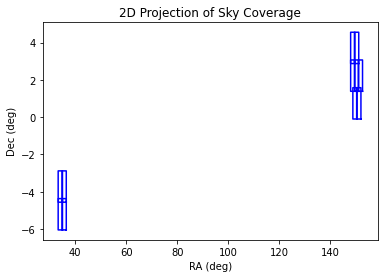

In [27]:
plt.figure()

for tract in tracts:
    tractInfo = skyMap[tract]
        
    corners = [(x[0].asDegrees(), x[1].asDegrees()) for x in tractInfo.getVertexList()]
    x = [k[0] for k in corners] + [corners[0][0]]
    y = [k[1] for k in corners] + [corners[0][1]]
    
       
    plt.plot(x,y, color='b')
    
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('2D Projection of Sky Coverage')

plt.show()

We could imagine plotting the patches as well, to show which tracts were incomplete - but this gives us a rough idea of where our data is on the sky.

## Finding a Coadd Object Catalog

Since we know we have `deepCoadd` images, we might want to find the sources detected in those images. These are the precursors of `Objects`. If forced photometry has been run on these sources, there should be `deepCoadd_forced_src` catalogs present. The `config` tells us which tasks have been run in the rerun, but metadata describing the results of the run is not propagated back into the registry database in the parent folder. So, we need to get data from the `under_butler`.

Since the registry only knows about the raw exposures (and products that can be directly derived from templates using the raws), we can't get valid metadata from `queryMetadata` directly. Instead, we query the directory structure for a valid filter, tract, patch combination.

In [28]:
dirname=os.path.join(repo,'deepCoadd-results')
print('filters: '+dirname)
!ls $dirname
filter='HSC-I'

dirname = os.path.join(dirname, filter)
print('\ntracts: '+dirname)
!ls $dirname
tract=8523

dirname = os.path.join(dirname,str(tract))
print('\npatches: '+dirname)
!ls $dirname
patch='1,3'

dirname = os.path.join(dirname,patch)
print('\ndata products: '+dirname)
!ls $dirname

filters: /datasets/hsc/repo/rerun/DM-10404/UDEEP/deepCoadd-results
HSC-G  HSC-I  HSC-R  HSC-Y  HSC-Z  merged  NB0816  NB0921

tracts: /datasets/hsc/repo/rerun/DM-10404/UDEEP/deepCoadd-results/HSC-I
10054  10055  8523  8524  8765	8766  9570  9571  9812	9813  9814

patches: /datasets/hsc/repo/rerun/DM-10404/UDEEP/deepCoadd-results/HSC-I/8523
0,1  0,5  1,1  1,5  2,1  2,5  3,1  3,5	4,1  4,5  5,2  5,6  6,4  6,8  7,6
0,2  0,6  1,2  1,6  2,2  2,6  3,2  3,6	4,2  4,6  5,3  5,7  6,5  7,3  7,7
0,3  0,7  1,3  1,7  2,3  2,7  3,3  3,7	4,3  4,7  5,4  5,8  6,6  7,4  7,8
0,4  0,8  1,4  1,8  2,4  2,8  3,4  3,8	4,4  4,8  5,5  6,3  6,7  7,5

data products: /datasets/hsc/repo/rerun/DM-10404/UDEEP/deepCoadd-results/HSC-I/8523/1,3
calexp-HSC-I-8523-1,3.fits	meas-HSC-I-8523-1,3.fits
det_bkgd-HSC-I-8523-1,3.fits	srcMatchFull-HSC-I-8523-1,3.fits
det-HSC-I-8523-1,3.fits		srcMatch-HSC-I-8523-1,3.fits
forced_src-HSC-I-8523-1,3.fits


We can also get some available tract, patches from the `skyMap` object. We need to feed it a list of coordinates defining a polygon to search for viable tract,patch info.

In [29]:
from lsst.geom import SpherePoint, Angle
# Create a list of corners of the polygon to search.
coordList = [SpherePoint(Angle(np.radians(0)),Angle(np.radians(-6))),
             SpherePoint(Angle(np.radians(0)),Angle(np.radians(-2))),
             SpherePoint(Angle(np.radians(40)),Angle(np.radians(-2))),
             SpherePoint(Angle(np.radians(40)),Angle(np.radians(-6)))
            ]
# Print the tract,patch info
tractInfo = skyMap.findTractPatchList(coordList)
for _tract in tractInfo:
    print(_tract[0])
    for _patch in _tract[1]:
        print('  ',_patch)

TractInfo(id=8500)
   PatchInfo(index=(0, 0))
   PatchInfo(index=(0, 1))
   PatchInfo(index=(0, 2))
   PatchInfo(index=(0, 3))
   PatchInfo(index=(0, 4))
   PatchInfo(index=(0, 5))
   PatchInfo(index=(0, 6))
   PatchInfo(index=(0, 7))
   PatchInfo(index=(0, 8))
   PatchInfo(index=(1, 0))
   PatchInfo(index=(1, 1))
   PatchInfo(index=(1, 2))
   PatchInfo(index=(1, 3))
   PatchInfo(index=(1, 4))
   PatchInfo(index=(1, 5))
   PatchInfo(index=(1, 6))
   PatchInfo(index=(1, 7))
   PatchInfo(index=(1, 8))
   PatchInfo(index=(2, 0))
   PatchInfo(index=(2, 1))
   PatchInfo(index=(2, 2))
   PatchInfo(index=(2, 3))
   PatchInfo(index=(2, 4))
   PatchInfo(index=(2, 5))
   PatchInfo(index=(2, 6))
   PatchInfo(index=(2, 7))
   PatchInfo(index=(2, 8))
   PatchInfo(index=(3, 0))
   PatchInfo(index=(3, 1))
   PatchInfo(index=(3, 2))
   PatchInfo(index=(3, 3))
   PatchInfo(index=(3, 4))
   PatchInfo(index=(3, 5))
   PatchInfo(index=(3, 6))
   PatchInfo(index=(3, 7))
   PatchInfo(index=(3, 8))
   PatchI

In [30]:
# Here we grab the coadd source catalog for a specific filter
dataId={'filter':'HSC-I','tract':tract,'patch':patch}
coadd_sources = under_butler.get('deepCoadd_forced_src',dataId=dataId)
coadd_sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,base_TransformedCentroid_x,slot_Centroid_x,base_TransformedCentroid_y,slot_Centroid_y,base_TransformedCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_3_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,undeblended_base_CircularApertureFlux_flag_badCentroid,undeblended_base_PsfFlux_flag_badCentroid,undeblended_ext_photometryKron_KronFlux_flag_badInitialCentroid,base_TransformedShape_xx,slot_Shape_xx,base_TransformedShape_yy,slot_Shape_yy,base_TransformedShape_xy,slot_Shape_xy,base_TransformedShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,modelfit_DoubleShapeletPsfApprox_0_xx,modelfit_DoubleShapeletPsfApprox_0_yy,modelfit_DoubleShapeletPsfApprox_0_xy,modelfit_DoubleShapeletPsfApprox_0_x,modelfit_DoubleShapeletPsfApprox_0_y,modelfit_DoubleShapeletPsfApprox_0_0,modelfit_DoubleShapeletPsfApprox_0_1,modelfit_DoubleShapeletPsfApprox_0_2,modelfit_DoubleShapeletPsfApprox_0_3,modelfit_DoubleShapeletPsfApprox_0_4,modelfit_DoubleShapeletPsfApprox_0_5,modelfit_DoubleShapeletPsfApprox_1_xx,modelfit_DoubleShapeletPsfApprox_1_yy,modelfit_DoubleShapeletPsfApprox_1_xy,modelfit_DoubleShapeletPsfApprox_1_x,modelfit_DoubleShapeletPsfApprox_1_y,modelfit_DoubleShapeletPsfApprox_1_0,modelfit_DoubleShapeletPsfApprox_1_1,modelfit_DoubleShapeletPsfApprox_1_2,modelfit_DoubleShapeletPsfApprox_flag,modelfit_DoubleShapeletPsfApprox_flag_invalidPointForPsf,modelfit_DoubleShapeletPsfApprox_flag_invalidMoments,modelfit_DoubleShapeletPsfApprox_flag_maxIterations,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_3_0_instFluxSigma,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_4_5_instFluxSigma,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_6_0_instFluxSigma,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_fluxSigma,base_CircularApertureFlux_9_0_instFluxSigma,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_12_0_instFluxSigma,base_CircularApertureFlux_12_0_instFluxErr,base_CircularApertureFlux_12_0_flag,base_CircularApertureFlux_12_0_flag_apertureTruncated,base_CircularApertureFlux_12_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_instFlux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_17_0_instFluxSigma,base_CircularApertureFlux_17_0_instFluxErr,base_CircularApertureFlux_17_0_flag,base_CircularApertureFlux_17_0_flag_apertureTruncated,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_instFlux,base_CircularApertureF

In [31]:
# We can also get the merged detections
dataId={'tract':8523,'patch':'1,8'}
merged_sources = under_butler.get('deepCoadd_mergeDet',dataId=dataId)

In [32]:
#One can get the available keys by running : 
#coadd_sources.getSchema()

## Visualizing Simple Measurements

We'd like to know something about the sources that have been detected and measured, beyond a simple total number. We create a simple histogram of the Kron flux of sources in our HSC-I band tile. You can find more details on merging catalogs across bands, etc on the [Science Pipelines documentation](https://pipelines.lsst.io/getting-started/multiband-analysis.html).

Text(0.5, 1.0, 'HSC-I 8523 1,3')

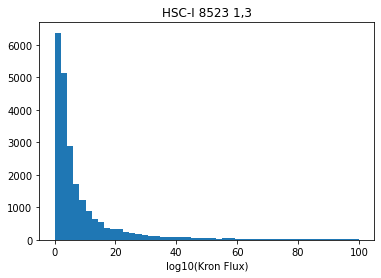

In [33]:
plt.figure()
plt.hist(coadd_sources['ext_photometryKron_KronFlux_flux'],bins=np.linspace(0,100,50))
plt.xlabel("log10(Kron Flux)")
plt.title("{filter} {tract} {patch}".format(filter=filter,tract=tract,patch=patch))

# Summary

We have shown a few techniques for exploring a data repo. ~~To make this process straightforward, we are implementing all these techniques into methods of a `Taster` class, which is now a part of the `stackclub` library. The `Taster` will give you a taste of what the `Butler` delivers. we demonstrate the use of this class in the [DataInventory.ipynb](https://github.com/LSSTScienceCollaborations/StackClub/blob/dc2_gen2/Graveyard/DataInventory.ipynb) notebook.~~

(Note:  the `Taster` class and the [DataInventory.ipynb](https://github.com/LSSTScienceCollaborations/StackClub/blob/dc2_gen2/Graveyard/DataInventory.ipynb) notebook are now both deprecated.  The DataInventory notebook is largely a demonstration of the `Taster` class, a useful tool that was created to augment the deficiencies of the Gen-2 butler for investigating and exploring data repos. Unfortunately, it depends on classes and repo structures that have evolved substantially over the past few years. Since the `Taster` resides outside of the DM Stack, it requires constant maintenance to be kept up-to-date with the Stack.  With the impending release of the Gen-3 butler, the `Taster` and the DataInventory notebook have been deprecated.)